In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy as sci
import pandas as pd
import torch.nn.functional as F
device = torch.device("cuda")

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class myLSTM(nn.Module):
    def __init__(self, hidden_dim, out_dim, input_size = 1, batch_size = 1):
        super(myLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.batch_size = batch_size
        self.LSTM = nn.LSTM(input_size, hidden_dim, batch_first = True)
        self.Linear = nn.Linear(hidden_dim, out_dim)
        self.Softmax = nn.Softmax(dim = 1)
        self.out_dim = out_dim
    
    def forward(self, input, hidden, batch = -1):

        if batch == -1:
            batch = self.batch_size

        input = torch.from_numpy(input).view(batch, -1, self.input_size).float().to(device = device)
        output, hidden_out = self.LSTM(input, hidden)

        input = hidden_out[0].view(batch, self.hidden_dim)
        out = self.Linear(input)

        out = self.Softmax(out)

        return output, out

    def initHidden(self, batch = -1):
        if batch == -1:
            batch = self.batch_size

        return (torch.zeros(1, batch, self.hidden_dim, device=device), torch.zeros(1, batch, self.hidden_dim, device=device))

In [3]:
#This time k is block width; Still not the general case 1D input
class myShaRNN_v1(nn.Module):
    def __init__(self, hidden_dim1, hidden_dim2, celltype, num_blocks, num_labels, input_dim1 = 1, batch_size = 1):
        super(myShaRNN_v1, self).__init__()
        if celltype == 'LSTM':
            cellType = nn.LSTM
        if celltype == 'GRU':
            cellType = nn.GRU

        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.batch_size = batch_size
        self.celltype = celltype
        
        self.num_blocks = num_blocks
        
        self.RNN1 = cellType(input_dim1, hidden_dim1, batch_first = True)
        self.RNN2 = cellType(hidden_dim1, hidden_dim2, batch_first = True)     
        self.Dense = nn.Linear(hidden_dim2, num_labels)
        self.Softmax = nn.Softmax(dim = 1)
    
    def forward(self, input, hidden, batch = -1):
        
        if batch == -1:
            batch = self.batch_size
        
        k = np.int(np.ceil(input.shape[2]/self.num_blocks))
        num_pad = self.num_blocks*k - input.shape[2]
        
        

        
        #paddding along [1]
        npad = ((0, 0), (0, 0), (0, num_pad))
        
        input = np.pad(input, pad_width = npad, mode = 'constant', constant_values = 0)
        
        

        input_length = int(input.shape[2]/self.num_blocks)
        
        input = torch.from_numpy(input.reshape(self.num_blocks*batch, -1, 1)).float().to(device = device)  
       

        output1, hidden1 = self.RNN1(input, hidden[0])

        input = hidden1[0].view(batch, -1, self.hidden_dim1)

        output2, hidden2 = self.RNN2(input, hidden[1])
        input = torch.squeeze(hidden2[0]).view(batch, -1)

        out = self.Dense(input)
        out = self.Softmax(out)


        return output2, out

    def initHidden(self, batch = -1, celltype = 'LSTM'):
        if batch == -1:
            batch = self.batch_size

        if celltype == 'LSTM':
            h1 = (torch.zeros(1, self.num_blocks*self.batch_size, self.hidden_dim1, device=device), torch.zeros(1, self.num_blocks*self.batch_size, self.hidden_dim1, device=device))
            h2 = (torch.zeros(1, self.batch_size, self.hidden_dim2, device=device), torch.zeros(1, self.batch_size, self.hidden_dim2, device=device))
            return [h1, h2]
        else:
            h1 = torch.zeros(1, self.num_blocks*self.batch_size, self.hidden_dim1, device=device)
            h2 = torch.zeros(1, self.batch_size, self.hidden_dim2, device=device)        
            return [h1, h2]

In [18]:
def correctf(o, y):
    y = torch.from_numpy(y).long().to(device)
    total, correct = 0, 0
    _, max = torch.max(o, 1)
    return torch.sum(max == y).float()





n_epochs = 1000
batch_size = 64



import torch.optim as optim
'''
#https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
'''


def train(model, n_epochs, optimizer, X, Y, lossfunction, batch_size):

    history = pd.DataFrame([])
    accs = []
    epochs_history = []
    loss = None
    for epoch in range(n_epochs):

        correct, total = 0, 0
        permutation = np.random.permutation(X.shape[0])

        for i in range(0, X.shape[0], batch_size):
            optimizer.zero_grad()

            indices = np.random.permutation(np.arange(i, i+batch_size))
            batch_x, batch_y = X[indices], Y[indices]

            hid = model.initHidden(batch = batch_size)
            _, outputs = model.forward(batch_x, hid)

            loss = lossfunction(outputs, torch.from_numpy(batch_y).long().to(device))

            loss.backward()
            optimizer.step()
            correct = correct + correctf(outputs, batch_y.reshape(batch_size))
            total = total + batch_size



        if epoch % 10 == 0:
            print('Loss: ', loss)
            print ('Accuracy:', correct, total, float(correct*100/total))
            accs.append(float(correct*100/total))
            epochs_history.append(epoch)

    history['epoch'] = epochs_history
    history['Accuracy'] = accs

    return history




In [4]:
import time
device = torch.device("cpu")


lstm = myLSTM(16, 30, 1, batch_size = 30).to(device)
sharnn = myShaRNN_v1(16, 16, 'LSTM', 8, 30, batch_size = 30).to(device) 
time_lstm = []
time_sharnn = []
length = []
for i in range(1, 10):
    data = np.random.randint(0, 100, size = (30, 1, 64*i))

    hid_lstm = lstm.initHidden()
    start = time.time()
    for j in range(1, 10):
        lstm.forward(data, hid_lstm)
    time_lstm.append((time.time() - start)/10)
    
    
    hid_sharnn = sharnn.initHidden()
    start = time.time()
    for j in range(1, 10):
        sharnn.forward(data, hid_sharnn)
    time_sharnn.append((time.time() - start)/10)
   
    length.append(64*i)


device = torch.device("cuda")


lstm = myLSTM(16, 30, 1, batch_size = 30).to(device)
sharnn = myShaRNN_v1(16, 16, 'LSTM', 8, 30, batch_size = 30).to(device)
time_lstm_gpu = []
time_sharnn_gpu = []

for i in range(1, 10):
    data = np.random.randint(0, 100, size = (30, 1, 64*i+i))

    
    hid_lstm = lstm.initHidden()
    start = time.time()
    for j in range(1, 10):
        lstm.forward(data, hid_lstm)
    time_lstm_gpu.append((time.time() - start)/10)
    
    
    hid_sharnn = sharnn.initHidden()
    start = time.time()
    for j in range(1, 10):
        sharnn.forward(data, hid_sharnn)
    time_sharnn_gpu.append((time.time() - start)/10)


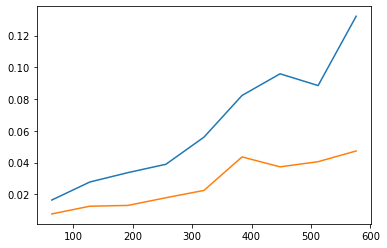

In [5]:
plt.plot(length, time_lstm, label = 'lstm')
plt.plot(length, time_sharnn, label = 'sharnn')
plt.show()

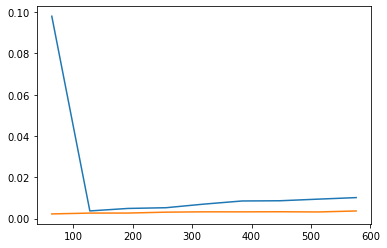

In [6]:
plt.ylim = 0.1
plt.plot(length, time_lstm_gpu, label = 'lstm')
plt.plot(length, time_sharnn_gpu, label = 'sharnn')
plt.show()

Loss:  tensor(0.7497, device='cuda:0', grad_fn=<NllLossBackward>)
Accuracy: tensor(10., device='cuda:0') 30 33.333335876464844
Loss:  tensor(0.6660, device='cuda:0', grad_fn=<NllLossBackward>)
Accuracy: tensor(20., device='cuda:0') 30 66.66667175292969
Loss:  tensor(0.5470, device='cuda:0', grad_fn=<NllLossBackward>)
Accuracy: tensor(20., device='cuda:0') 30 66.66667175292969
Loss:  tensor(0.4895, device='cuda:0', grad_fn=<NllLossBackward>)
Accuracy: tensor(20., device='cuda:0') 30 66.66667175292969
Loss:  tensor(0.4894, device='cuda:0', grad_fn=<NllLossBackward>)
Accuracy: tensor(20., device='cuda:0') 30 66.66667175292969
Loss:  tensor(0.4876, device='cuda:0', grad_fn=<NllLossBackward>)
Accuracy: tensor(20., device='cuda:0') 30 66.66667175292969
Loss:  tensor(0.4873, device='cuda:0', grad_fn=<NllLossBackward>)
Accuracy: tensor(20., device='cuda:0') 30 66.66667175292969
Loss:  tensor(0.4872, device='cuda:0', grad_fn=<NllLossBackward>)
Accuracy: tensor(20., device='cuda:0') 30 66.666671

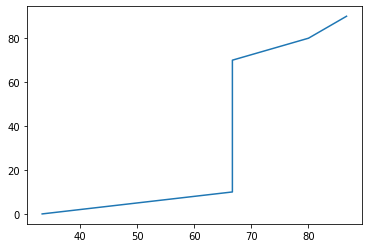

In [21]:
device = torch.device("cuda")
data = np.random.randint(0, 100, size = (30, 1, 64))
label = np.random.randint(2, size = (30))
batch_size = 10
sharnn = myShaRNN_v1(16, 16, 'LSTM', 4, 2, batch_size = batch_size).to(device)

lossfunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(sharnn.parameters(), lr = 0.001)


history = train(sharnn, 100, optimizer, data, label, lossfunction, batch_size)
plt.plot(history['Accuracy'], history['epoch'])
plt.show()
